In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

%matplotlib inline


Using TensorFlow backend.


In [2]:
train = pd.read_csv('all/sales_train.csv')
test = pd.read_csv('all/test.csv')
submission = pd.read_csv('all/sample_submission.csv')
items = pd.read_csv('all/items.csv')
item_cats = pd.read_csv('all/item_categories.csv')
shops = pd.read_csv('all/shops.csv')
print("Ok")

Ok


In [3]:
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)

In [4]:
# print(train)

In [5]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
# fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
# num_graph = 10
# id_per_graph = ceil(grouped.shop_id.max() / num_graph)
# count = 0
# for i in range(5):
#     for j in range(2):
#         sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', 
#                     data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], 
#                     grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
#         count += 1

In [6]:
# add categories
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()


train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

# fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
# num_graph = 10
# id_per_graph = ceil(train.item_category_id.max() / num_graph)
# count = 0
# for i in range(5):
#     for j in range(2):
#         sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
#                       data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
#                       ax=axes[i][j])
#         count += 1

In [7]:
# print(train)
copytrain = train

In [8]:
train = train.drop('date', axis=1)
train = train.drop('item_category_id', axis=1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train = train.sort_index()

# print(train)

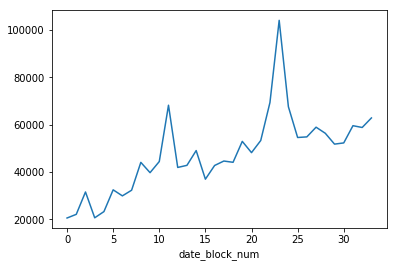

In [9]:
train2 = copytrain
train2 = train2.drop('date', axis=1)
train2 = train2.drop('item_category_id', axis=1)
train2 = train2.drop('item_id', axis=1)
train2 = train2.drop('shop_id', axis=1)
# train2 = train2.drop('year', axis=1)
# train2 = train2.drop('month', axis=1)
# train2 = train2.drop('date_block_num', axis=1)
# train2 = train2.groupby(['shop_id', 'item_category_id','year']).sum()
train2 = train2.groupby(['date_block_num']).sum()
train2 = train2.sort_index()
train2['item_cnt_day'].plot()
# train2

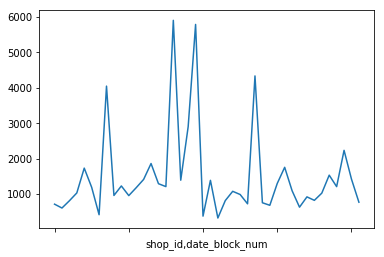

In [10]:
train2 = copytrain
train2 = train2.drop('date', axis=1)
train2 = train2.drop('item_category_id', axis=1)
train2 = train2.drop('item_id', axis=1)
# train2 = train2.drop('shop_id', axis=1)
# train2 = train2.drop('year', axis=1)
# train2 = train2.drop('month', axis=1)
# train2 = train2.drop('date_block_num', axis=1)
# train2 = train2.groupby(['shop_id', 'item_category_id','year']).sum()
# train2 = train2['date_block_num'] =33
train2 = train2.loc[train2['date_block_num'] == 33]
train2 = train2.groupby(['shop_id','date_block_num']).sum()
train2 = train2.sort_index()
# train2 = [train2['date_block_num'] == 33]
train2['item_cnt_day'].plot()
# train2

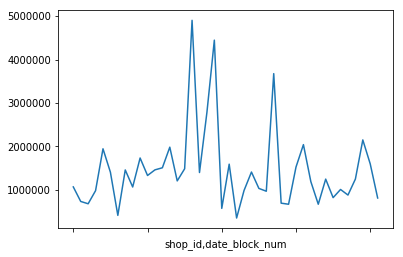

In [11]:

train2['item_price'].plot()

In [12]:
scaler = StandardScaler()
cnt_scaler = StandardScaler()

# print(train.item_price.values)
scaler.fit(train.item_price.values.reshape(-1, 1))
# # scaler.fit(train.item_price.as_matrix().reshape(-1, 1))
cnt_scaler.fit(train.item_cnt_day.values.reshape(-1, 1))

train.item_price = scaler.transform(train.item_price.values.reshape(-1, 1))
train.item_cnt_day = cnt_scaler.transform(train.item_cnt_day.values.reshape(-1, 1))

In [13]:
# train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

In [14]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()
# price

In [15]:
# print(train)

In [16]:
def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):
    """Find the block_date which is closest to the current_day, given item_id and shop_id. Returns index integer"""
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)

In [17]:
assert closest_date_block(18, 30, 5) == 18

In [18]:
# Some simple math to know what date_block_num to start learning
print(convert(6))
print(convert(18))
print(convert(30))
print(convert(7))
print(convert(8))
print(convert(9))
print(convert(10))
print(convert(11))
print(convert(12))

(7, 2013)
(7, 2014)
(7, 2015)
(8, 2013)
(9, 2013)
(10, 2013)
(11, 2013)
(12, 2013)
(1, 2014)


In [19]:
import time
# start_time = time.time()
# main()
# print("--- %s seconds ---" % (time.time() - start_time))

In [20]:
# price

In [21]:
# train
# print(test_shops)
count = 0
for s in test_shops:
    count = count + len(list(train.loc[s].index.get_level_values(0).unique()))
print(count)
# shop_items = list(train.loc[test_shops[0]].index.get_level_values(0).unique())
# print(len(shop_items)

111404


In [22]:
maxlen = 12
a = len(train.index)
# a = int(a/10)
print(a)
count = 0
m_count = 12
train_start = 9
test_start = 21
sentences = [[],[]]
next_chars = [[],[]]
# print(train['item_price'].tolist()[0])
i=0
# start_time1 = time.time()
time1 = 0
# start_time1 = time.time()
time2 = 0
# start_time1 = time.time()
# start_time1 = time.time()
time3 = 0
while i < a:
    count = count + 1
    b = train.index[i]
    shop = b[0]
    item = b[1]
    date = b[2]
    sentence = []
    date2 = date

    start_time = time.time()
    if i+1 < a:
        bb = train.index[i+1]
        while (bb[2] < 12) and (shop == bb[0]) and (item == bb[1]) and(i+1 < a): 
            b = bb
            date = b[2]
            if (i+1<a):
                i = i+1
                bb = train.index[i+1]
    else:
        date2 = 900
    prev_price = train.loc[b].to_dict()['item_price']
    if (i+1<a):
        i = i+1
    b = train.index[i]
    if (shop == b[0]) and (item == b[1]):
        date2 = b[2]
    else:
        date2 = 900
    month = 0
    
    time1 = time1+time.time()-start_time
    
    while month < 12:
        if month+train_start<date2:
            row = {'shop_id': shop, 'item_cnt_day': 0, 
                'month': month, 'item_id': item, 'item_price': prev_price}
        else:
            aa = train.loc[b].to_dict()
            prev_price = aa['item_price']
            row = {'shop_id': shop, 'item_cnt_day': aa['item_cnt_day'], 
                'month': month, 'item_id': item, 'item_price': prev_price}
            if (i+1<a):
                i = i+1
            b = train.index[i]
            if (shop == b[0]) and (item == b[1]):
                date2 = b[2]
            else:
                date2 = 900
            
        sentence.append(row)
        month = month + 1
        
        
    row={}
    if month+train_start<date2:
        row = {'shop_id': shop, 'item_cnt_day': 0, 
            'month': month, 'item_id': item, 'item_price': prev_price}
    else:
        aa = train.loc[b].to_dict()
        prev_price = aa['item_price']
        row = {'shop_id': shop, 'item_cnt_day': aa['item_cnt_day'], 
            'month': month, 'item_id': item, 'item_price': prev_price}
    next_chars[0].append(row)            
    
    sentences[0].append(sentence)
    
    time2 = time2 + time.time() - start_time
    sentence = []
    month = 0
    while month < 12:
        if month+test_start<date2:
            row = {'shop_id': shop, 'item_cnt_day': 0, 
                'month': month, 'item_id': item, 'item_price': prev_price}
        else:
            aa = train.loc[b].to_dict()
            prev_price = aa['item_price']
            row = {'shop_id': shop, 'item_cnt_day': aa['item_cnt_day'], 
                'month': month, 'item_id': item, 'item_price': prev_price}
            if (i+1<a):
                i = i+1
            b = train.index[i]
            if (shop == b[0]) and (item == b[1]):
                date2 = b[2]
            else:
                date2 = 900
        
        sentence.append(row)
        month = month + 1
    sentences[1].append(sentence)
    
    row={}
    if month+train_start<date2:
        row = {'shop_id': shop, 'item_cnt_day': 0, 
            'month': month, 'item_id': item, 'item_price': prev_price}
    else:
        aa = train.loc[b].to_dict()
        prev_price = aa['item_price']
        row = {'shop_id': shop, 'item_cnt_day': aa['item_cnt_day'], 
            'month': month, 'item_id': item, 'item_price': prev_price}
    next_chars[1].append(row)  
    
    time3 = time3 + time.time() - start_time
#     print(i)
    if (i +1 == a):
         i = i+1
    if (count%1000 == 0):
        print(count)
            
# print("--- %s seconds ---" % (time.time() - start_time))
print("--- %s seconds ---" % (time1))
print("--- %s seconds ---" % (time2-time1))
print("--- %s seconds ---" % (time3-time2))
print("--- %s seconds ---" % (time3))
#     print(train.index[i])
#     print(train.loc[b].to_dict())


#     if count%10000 == 0:
#         print(count)
#     print(b)
print(train.index[0])
# # print(train[train.index[0]])
print(train.index[1])
print(train.index[2])
# print(train.index[3])
# print(train.index[4])
# print(train.index[5])
# print(train.index[6])
# print(train.index[8])
# print(train.index[9])
# train.head(1)

600159
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
--- 49.97146701812744 seconds ---
--- 45.793606996536255 seconds ---
--- 81.86877465248108 seconds ---
--- 177.63384866714478 seconds ---
(2, 30, 2, '03', '2013')


In [23]:
print(len(next_chars[1]))
print(len(next_chars[0]))
print(len(sentences[0]))
print(len(sentences[1]))

134126
134126
134126
134126


In [24]:

sentences[1][1]

[{'shop_id': 2,
  'item_cnt_day': 0,
  'month': 0,
  'item_id': 31,
  'item_price': -0.24054819048222115},
 {'shop_id': 2,
  'item_cnt_day': 0,
  'month': 1,
  'item_id': 31,
  'item_price': -0.24054819048222115},
 {'shop_id': 2,
  'item_cnt_day': 0,
  'month': 2,
  'item_id': 31,
  'item_price': -0.24054819048222115},
 {'shop_id': 2,
  'item_cnt_day': 0,
  'month': 3,
  'item_id': 31,
  'item_price': -0.24054819048222115},
 {'shop_id': 2,
  'item_cnt_day': 0,
  'month': 4,
  'item_id': 31,
  'item_price': -0.24054819048222115},
 {'shop_id': 2,
  'item_cnt_day': 0,
  'month': 5,
  'item_id': 31,
  'item_price': -0.24054819048222115},
 {'shop_id': 2,
  'item_cnt_day': 0,
  'month': 6,
  'item_id': 31,
  'item_price': -0.24054819048222115},
 {'shop_id': 2,
  'item_cnt_day': 0,
  'month': 7,
  'item_id': 31,
  'item_price': -0.24054819048222115},
 {'shop_id': 2,
  'item_cnt_day': 0,
  'month': 8,
  'item_id': 31,
  'item_price': -0.24054819048222115},
 {'shop_id': 2,
  'item_cnt_day': 0,


In [25]:
train

item_price  item_cnt_day
shop_id item_id date_block_num month year                          
2       30      2              03    2013   -0.248665     -0.150189
                5              06    2013   -0.242961     -0.150189
                15             04    2014   -0.275760     -0.150189
                16             05    2014   -0.275760     -0.150189
        31      1              02    2013    0.098859      0.115543
                2              03    2013   -0.200251     -0.150189
                3              04    2013   -0.200180     -0.150189
                16             05    2014   -0.240548     -0.150189
                33             10    2015   -0.242961     -0.150189
        32      12             01    2014   -0.282890     -0.150189
                14             03    2014   -0.278612     -0.150189
                18             07    2014   -0.278612     -0.150189
                20             09    2014   -0.257364     -0.061612
                21             10    2014   -0.257364     -0.061612
                23             12    2014   -0.257364     -0.061612
                26             03    2015   -0.278612     -0.150189
                31             08    2015   -0.278612     -0.150189
        33      0              01    2013   -0.228701     -0.150189
                10             11    2013   -0.243104     -0.061612
                11             12    2013   -0.271482     -0.150189
                12             01    2014   -0.271482     -0.150189
                20             09    2014   -0.271482     -0.150189
                25             02    2015   -0.271482     -0.150189
                27             04    2015   -0.271482     -0.150189
                28             05    2015   -0.271482     -0.150189
                30             07    2015   -0.271482     -0.150189
                32             09    2015   -0.271482     -0.150189
        53      25             02    2015   -0.257221     -0.150189
        59      25             02    2015   -0.264352     -0.150189
        67      24             01    2015   -0.278612     -0.150189
...                                               ...           ...
59      22092   26             03    2015   -0.248808      0.026965
                31             08    2015   -0.274334     -0.150189
        22100   32             09    2015   -0.210162     -0.150189
                33             10    2015   -0.210162     -0.150189
        22102   29             06    2015   -0.121606     -0.150189
                31             08    2015    0.056648     -0.061612
                33             10    2015   -0.121606     -0.150189
        22104   29             06    2015   -0.264352     -0.150189
        22105   24             01    2015   -0.257221     -0.150189
                30             07    2015   -0.271482     -0.150189
                31             08    2015   -0.271482     -0.150189
        22106   24             01    2015   -0.257221     -0.150189
        22118   26             03    2015   -0.285742     -0.150189
        22139   24             01    2015   -0.200180     -0.150189
                32             09    2015   -0.228701     -0.150189
        22145   14             03    2014   -0.064992      0.026965
                20             09    2014   -0.221571     -0.150189
        22154   0              01    2013   -0.157399     -0.150189
        22162   25             02    2015    0.212228      0.558428
                26             03    2015   -0.072265      0.115543
                27             04    2015   -0.250091     -0.150189
                28             05    2015   -0.250091     -0.150189
                31             08    2015   -0.250091     -0.150189
        22164   25             02    2015   -0.086240     -0.061612
                26             03    2015   -0.193050     -0.150189
                27             04    2015   -0.100500     -0.061612
                30             

In [26]:
# # maxlen = 4 # 4 months
# maxlen = 12
# step = 1
# # 0: train, 1: val, 2:test
# # sentences = [[],[],[]]
# sentences = [[],[]]
# next_chars = []
# # BLOCKS = [6, 18, 30]
# BLOCKS = [10, 22]

# count = 0

# for s in test_shops:
#     shop_items = list(train.loc[s].index.get_level_values(0).unique())
#     print(count)
#     count = count + 1
#     for it in shop_items:     
# #         print(count)   
# #         start_time = time.time()  
#         for i_index, i in enumerate(BLOCKS):
#             sentence = []
# #             print(i_index, i)
# #             start_time = time.time()  
#             closest_pc = 0
#             for j in range(maxlen+1):
#                 if j < maxlen:
# #                     if (s, it, i+j) in train.index:
# #                         r = train.loc[(s, it, i + j)].to_dict(orient='list')                    
# #                         closest_pc = r['item_price'][0]
# #                         item_cnt_day = r['item_cnt_day'][0]
# #                         row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
# #                                'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
# #                     else:
# #                         closest_pc = closest_price(i, it, s)     
# #                         month, year = convert(i+j)                    
# #                         row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
# #                                'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
#                     month, year = convert(i+j)                    
#                     row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
#                            'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
#                     sentence.append(row)
# #                     count = count + 1
#                 elif i_index < 2:   # not in test set
#                     next_chars.append(row)   
#             sentences[i_index].append(sentence)
        
#         print("--- %s seconds ---" % (time.time() - start_time)) 

In [27]:

# MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 12 # 7 8 9 10
MAX_SHOP = len(test_shops)

x_train_o = np.array(sentences[0])
x_val_o = np.array(sentences[1])
# x_test_o = np.array(sentences[1])
y_train = np.array([x['item_cnt_day'] for x in next_chars[0]])
y_val = np.array([x['item_cnt_day'] for x in next_chars[1]])

length = MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1 + 1

In [28]:
print(len(x_train_o))
print(len(x_val_o))
print(len(y_train))
print(len(y_val))

134126
134126
134126
134126


In [29]:
from sklearn import preprocessing

shop_le = preprocessing.LabelEncoder()
shop_le.fit(test_shops)
shop_dm = dict(zip(test_shops, shop_le.transform(test_shops)))

item_le = preprocessing.LabelEncoder()
item_le.fit(test_items)
item_dm = dict(zip(test_items, item_le.transform(test_items)))

month_le = preprocessing.LabelEncoder()
month_le.fit(range(7,11))
month_dm = dict(zip(range(7,11), month_le.transform(range(7,11))))

In [30]:
# print(len(x_test_o), maxlen, length)
# x = np.zeros((11140,12,5157), dtype=np.float32)
# print(shop_dm)
# print(len(x_train_o[12345]))
# del x_train_o
del x_train
del x_val
# del y_train


NameError: name 'x_train' is not defined

In [31]:
part = 10
max_item = int(MAX_ITEM/part)

length = MAX_SHOP + max_item + MAX_MONTH + 1 + 1 + 1
print(max_item, length)
def vectorize(inp):
    print('Vectorization...')   
    print(len(inp), maxlen, length)
    x = np.zeros((len(inp), maxlen, length), dtype=np.float32)
    for i, sentence in enumerate(inp):
        for t, char in enumerate(sentence):    
#             print(char)
            x[i][t][ shop_dm[char['shop_id']] ] = 1  
#             print(int(char['item_id']/10))
            x[i][t][ MAX_SHOP + int(item_dm[char['item_id']]/part)] = (item_dm[char['item_id']]/part-int(item_dm[char['item_id']]/part) -1)*1.99
            x[i][t][ MAX_SHOP + max_item + char['month'] + 1 ] = 1
            x[i][t][ MAX_SHOP + max_item + MAX_MONTH + 1 ] = char['item_price']
            x[i][t][ MAX_SHOP + max_item + MAX_MONTH + 1 + 1] = char['item_cnt_day']    
    return x

maxlen = 12
# x = np.zeros((11140,12,5157), dtype=np.float32)
x_train = vectorize(x_train_o)
# xx = np.zeros((11140,12,5157), dtype=np.float32)
x_val = vectorize(x_val_o)

510 567
Vectorization...
134126 12 567
Vectorization...
134126 12 567


In [94]:
del model

In [32]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(32, input_shape=(maxlen, length)))
model.add(Dense(1, activation='relu'))

optimizer = RMSprop(lr=0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.fit(x_train, y_train, batch_size=2048, epochs=6)

Build model...
Epoch 1/6
134126/134126 [==============================] - 7s 51us/step - loss: 0.0648
Epoch 2/6
134126/134126 [==============================] - 5s 38us/step - loss: 0.0474
Epoch 3/6
134126/134126 [==============================] - 5s 38us/step - loss: 0.0407
Epoch 4/6
134126/134126 [==============================] - 5s 37us/step - loss: 0.0356
Epoch 5/6
134126/134126 [==============================] - 5s 37us/step - loss: 0.0317
Epoch 6/6
134126/134126 [==============================] - 5s 37us/step - loss: 0.0279


In [30]:


from keras.models import load_model

model.save('my_model2.h5') 

In [37]:
print(len(predict_val), len(y_val))
print(len(predict_train), len(y_train))
print(len(x_val))

NameError: name 'predict_val' is not defined

In [33]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
predict_train = model.predict(x_train)
predict_val = model.predict(x_val)
# invert predictions
predict_train = cnt_scaler.inverse_transform(predict_train)
y_train = cnt_scaler.inverse_transform(y_train)
predict_val = cnt_scaler.inverse_transform(predict_val)
y_val = cnt_scaler.inverse_transform(y_val)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(predict_train, y_train))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(predict_val, y_val))
print('Test Score: %.2f RMSE' % (valScore))
#For 1 epoch
# Train Score: 2.31 RMSE
# Test Score: 1.42 RMSE


Train Score: 1.80 RMSE
Test Score: 1.98 RMSE


In [95]:
del predict_train
del predict_val

In [58]:
model.fit(x_val, y_val, batch_size=2048, epochs=13)

Epoch 1/13
111404/111404 [==============================] - 19s 172us/step - loss: 9.2909
Epoch 2/13
111404/111404 [==============================] - 19s 172us/step - loss: 7.6454
Epoch 3/13
111404/111404 [==============================] - 19s 173us/step - loss: 6.8270
Epoch 4/13
111404/111404 [==============================] - 19s 173us/step - loss: 6.0881
Epoch 5/13
111404/111404 [==============================] - 19s 174us/step - loss: 5.6661
Epoch 6/13
111404/111404 [==============================] - 19s 173us/step - loss: 5.3044
Epoch 7/13
111404/111404 [==============================] - 19s 173us/step - loss: 5.0030
Epoch 8/13
111404/111404 [==============================] - 19s 172us/step - loss: 4.6944
Epoch 9/13
111404/111404 [==============================] - 19s 173us/step - loss: 4.3458
Epoch 10/13
111404/111404 [==============================] - 19s 171us/step - loss: 4.1903
Epoch 11/13
111404/111404 [==============================] - 19s 172us/step - loss: 3.9588
Epoch 12

In [43]:
predict_test = model.predict(x_test)
predict_test = cnt_scaler.inverse_transform(predict_test)

In [44]:

test = pd.read_csv('all/test.csv')
test = test.set_index(['shop_id', 'item_id'])
test['item_cnt_month'] = 0

for index, sentence in enumerate(x_test_o):
    (shop_id, item_id) = (sentence[0]['shop_id'], sentence[0]['item_id'])
    test.loc[(shop_id, item_id)]['item_cnt_month'] = predict_test[index]
    
    

test = test.reset_index().drop(['shop_id', 'item_id'], axis=1)
test.to_csv('submission2.csv', index=False)
